In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [5]:
import fitz  # PyMuPDF
from langchain_core.documents import Document
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch
import numpy as np
from langchain.chat_models import init_chat_model
from langchain.prompts import PromptTemplate
from langchain.schema.messages import HumanMessage
from sklearn.metrics.pairwise import cosine_similarity
import os
import base64
import io
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS

C:\Users\oybek\RAG_udemy\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from dotenv import load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

## initialize the CLip Model for unified emceddings

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_precossor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model.eval()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Fetching 1 files: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 834.52it/s]


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [ ]:
clip_precossor()

In [11]:
## Embedding functions

def embed_image(image_data):
    """ Embed image using CLIP"""
    if isinstance(image_data, str):
        image = Image.open(image_data).convert("RGB")

    else:
        image = image_data
    inputs = clip_precossor(images = image, return_tensors='pt')
    with torch.no_grad():
        features = clip_model.get_image_features(**inputs)
        # Normalize embeddings to unit vector
        features = features/features.norm(dim = -1, keepdim = True)
        return features.squeeze().numpy()
def embed_text(text):
    "Embed text using CLIP"
    inputs = clip_precossor(
        text = text,
        return_tensors="pt",
        padding = True,
        truncation = True,
        max_length = 77
    )

    with torch.no_grad():
        features = clip_model.get_text_features(**inputs)
        ## Normaliza embeddings
        features = features / features.norm(dim = 1, keepdim = True)
        return features.squeeze().numpy()
    

In [65]:
# pdf = "multimodal_sample.pdf"
pdf = "Automated_classification_of_chondroid_tumor_using_.pdf"

doc  = fitz.open(pdf)

all_docs = []
all_embeddings = []
image_data_store = {}
# text splitter

splitter = RecursiveCharacterTextSplitter(chunk_size = 500, chunk_overlap = 100)

In [126]:
splitter

In [67]:
import fitz  # PyMuPDF
from PIL import Image
import io
import matplotlib.pyplot as plt

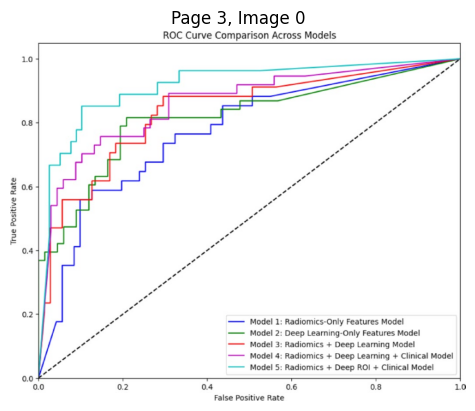

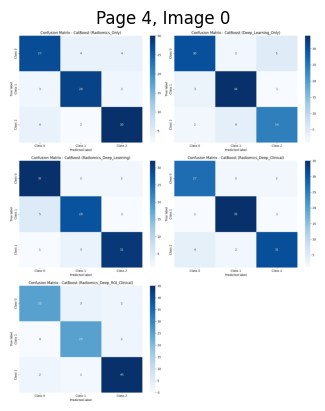

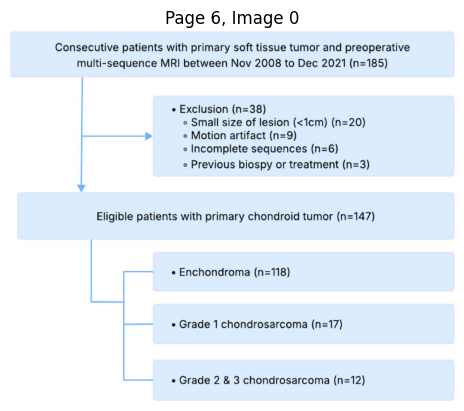

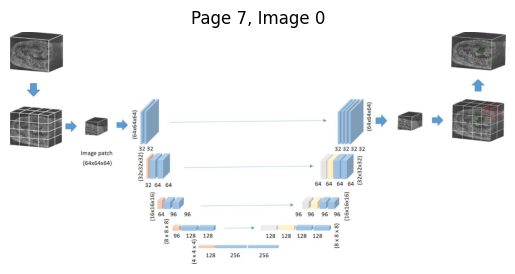

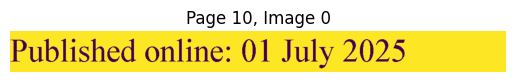

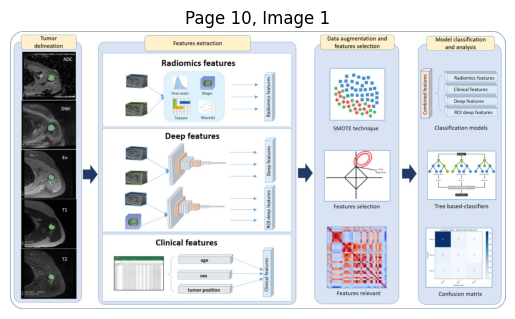

In [69]:
for i, page in enumerate(doc):
    # print(i)
    text = page.get_text()
    if text.strip():
        temp_doc = Document(page_content = text, metadata={'page':i, "type": "text"})
        # print(temp_doc)
        text_chunks = splitter.split_documents([temp_doc])
        # print("\n")
        for chunks in text_chunks:
            # print(chunks.page_content)
            emb = embed_text(chunks.page_content)
            
    for img_index, img in enumerate(page.get_images(full=True)):
        try:
            xref = img[0]
            base_image = doc.extract_image(xref)
            image_bytes =base_image["image"]
            image = Image.open(io.BytesIO(image_bytes))
            plt.figure()
            plt.imshow(image)
            plt.axis("off")
            plt.title(f"Page {i}, Image {img_index}")
            plt.show()

        except Exception as e:
            print("Image extraction error:", e)
            
  

In [71]:
for i, page in enumerate(doc):
    text = page.get_text()
    if text.strip():
        temp_doc = Document(page_content=text, metadata={"page":i, "type": "text"})
        text_chunks = splitter.split_documents([temp_doc])

        # Embed each chunk using CLIP
        for chunk in text_chunks:
            embedding = embed_text(chunk.page_content)
            all_embeddings.append(embedding)
            all_docs.append(chunk)

    # three important Actions
    #
    ## Convert PDF image to PIL format
    ## Store as base64 for GPT-4V ( which needs base64 images)
    ## Create CLIP embedding for retrieval
    for img_index, img in enumerate(page.get_images(full = True)):
        try:
            xref = img[0]
            base_image = doc.extract_image(xref)
            image_types = base_image["image"]

            # Convert to PIL image
            pil_image = Image.open(io.BytesIO(image_types)).convert("RGB")
            # Create unique identifier
            image_id = f"page_{i}_image{img_index}"
            # Store image as base64 for later use with GPT-4V
            buffered = io.BytesIO()
            pil_image.save(buffered, format = "PNG")
            img_base64 = base64.b64encode(buffered.getvalue()).decode()
            image_data_store[image_id] = img_base64

             # Embed image using CLIP
            embedding  = embed_image(pil_image)
            all_embeddings.append(embedding)
            ## Create document for image
            image_doc = Document(
                page_content= f"[Image:{image_id}]",
                metadata = {'page':i, "type":"image", "image_id": image_id}
            )
            all_docs.append(image_doc)
        except Exception as e:
            print(f"Error processing image {img_index} on page {i}: {e}")
            continue
doc.close()
            
    

In [72]:
all_docs

[Document(metadata={'page': 0, 'type': 'text'}, page_content='Automated classification of \nchondroid tumor using 3D U-Net \nand radiomics with deep features\nTuan\xa0Le\xa0Dinh2, Seungeun\xa0Lee1, Hyemin\xa0Park1, Sungwon\xa0Lee1,2, Hyeondeok\xa0Choi1,2,  \nKeum San\xa0Chun2 & Joon-Yong\xa0Jung1,2\uf02a\nClassifying chondroid tumors is an essential step for effective treatment planning. Recently, with \nthe advances in computer-aided diagnosis and the increasing availability of medical imaging data,'),
 Document(metadata={'page': 0, 'type': 'text'}, page_content='the advances in computer-aided diagnosis and the increasing availability of medical imaging data, \nautomated tumor classification using deep learning shows promise in assisting clinical decision-\nmaking. In this study, we propose a hybrid approach that integrates deep learning and radiomics \nfor chondroid tumor classification. First, we performed tumor segmentation using the nnUNetv2 \nframework, which provided three-dimen

In [75]:
embedding_array = np.array(all_embeddings)
embedding_array

array([[ 0.04767875,  0.01529459, -0.02271391, ..., -0.01590919,
        -0.00381962, -0.04477729],
       [ 0.04758787, -0.00072834,  0.02156313, ...,  0.02953343,
         0.02881004, -0.04608358],
       [ 0.03506878,  0.00048281,  0.00863177, ..., -0.02047004,
        -0.02240899, -0.02791996],
       ...,
       [-0.00144114,  0.0214675 ,  0.02267561, ..., -0.02001661,
         0.00954033, -0.00267065],
       [ 0.00254923,  0.03660598, -0.00134709, ..., -0.01615056,
        -0.00674243, -0.02528936],
       [ 0.03248447,  0.01593721, -0.01845942, ..., -0.1308166 ,
        -0.03810966,  0.00671219]], shape=(142, 512), dtype=float32)

In [ ]:
(all_docs, embedding_array)

In [31]:
## Create custom FAISS index since we have precomputed embeddings

vector_store = FAISS.from_embeddings(
    text_embeddings = [(doc.page_content, emb) for doc, emb in zip(all_docs, embedding_array)],
    embedding= None,
    metadatas = [doc.metadata for doc in all_docs]
)

vector_store

`embedding_function` is expected to be an Embeddings object, support for passing in a function will soon be removed.


In [49]:
## initialize GPT-4 vision model

llm = init_chat_model("openai:gpt-4.1")
llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x000001F4050C0260>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000001F40511E750>, root_client=<openai.OpenAI object at 0x000001F4050C14F0>, root_async_client=<openai.AsyncOpenAI object at 0x000001F47E5A43B0>, model_name='gpt-4.1', model_kwargs={}, openai_api_key=SecretStr('**********'))

In [33]:
def retrieve_multimodal(query, k=5):
    """ Unified retrieval using CLIP embeddings for both text and images."""
    query_embedding = embed_text(query)
    # Search in unified vector store
    results = vector_store.similarity_search_by_vector(
        embedding = query_embedding,
        k = k
    )
    return results
    

In [59]:
def create_multimodel_message(query, retrieved_docs):
    """ Create a message with both text and images for GPT-4v"""
    content = []

    # add query
    content.append({
        "type": "text",
        "text" : f'Question: {query}\n\nContext:\n.'
    })
    # Separate text and image documents
    text_docs = [doc for doc in retrieved_docs if doc.metadata.get("type") == "text"]
    image_docs = [doc for doc in retrieved_docs if doc.metadata.get("type") == "image"]


    # Add text context
    if text_docs:
        text_context = "\n\n".join([
            f"[Page {doc.metadata["page"]}]: {doc.page_content}" for doc in text_docs
        ])
        content.append({
            "type": "text",
            "text": f"Text excerpts:\n{text_context}\n"
        })
        content.append({
            'type': "image_url",
            "image_url" : {
                "url": f"data:image/png;base64,{image_data_store[image_id]}"
            }
        })
        ## Add instruction
        content.append({
            "type": "text",
            "text": "\n\nPlease answer the question based on the provided text and image."
        })
        return HumanMessage(content=content)

In [61]:
def multimodal_pdf_rag_pipeline(query):
    """Main pipeline for multimodal RAG"""
    # Retrieve relevant message
    context_docs = retrieve_multimodal(query, k=5)
    # Create multimodal message
    message  = create_multimodel_message(query, context_docs)

    # Get response from GPT
    response = llm.invoke([message])

    # print retrieved context info
    print(f"\nRetrieved {len(context_docs)} documents:")
    for doc in context_docs:
        doc_type = doc.metadata.get("type", "unknown")
        page = doc.metadata.get("page", "?")
        if doc_type == "text":
            preview = doc.page_content[:100] + "..." if len(doc.page_content)>100 else doc.page_content
            print(f" - Text from page {page} : {preview}")
        else:
            print(f" - Image from page {page}")
    print("\n")
    return response.content

In [63]:
if __name__ == "__main__":
    queries = [
        "What is the novelty of this paper?",
        "What is the main purpose of this paper?"
    ]
    for query in queries:
        print(f"\nQuery: {query}")
        print("-" * 50)
        answer = multimodal_pdf_rag_pipeline(query)
        print(f"Answer: {answer}")
        print("=" * 70)
        


Query: What is the novelty of this paper?
--------------------------------------------------

Retrieved 5 documents:
 - Text from page 5 : 0.669±0.183 
0.681±0.190 
SVM Meta 
0.659±0.088 
0.684±0.070 
0.664±0.097 
0.685±0.181 
0.683±0.193 ...
 - Text from page 3 : mensionality, while clinical profiles were retained in their original form. Class imbal-
ance was su...
 - Text from page 5 : 0.706±0.135 
LR Meta 
0.705 ±0.070 
0.706±0.057 
0.710±0.074 
0.782±0.163 
0.638±0.157 
SVM Meta 
0....
 - Text from page 6 : bility.  To accommodate the heterogeneous nature of radiomic and clinical data, we 
adopted a two-st...
 - Text from page 1 : to rarer genes such as IFT140, GANAB, DNAJB11, and ALG9[7-9]. Moreover, disease 
severity varies sig...


Answer: Based on the provided text excerpts and the image, **the novelty of this paper** lies in the following key aspects:

---

### 1. **Multimodal Fusion Approach for Risk Stratification**
- The paper proposes a **multimodal fusion** of **radiomic